Building risk management tool
*   Using ARIMA model for forecasting close price
*   Using ADF (Augmented Dickey-Fuller) Test for stationarity
*   Applying GARCH model



# IMPORT LIBRARY

In [ ]:
!pip install numpy==1.26.4
!pip install pmdarima
!pip install arch

In [23]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
# Correct import for ARIMA model
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from pylab import rcParams
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from arch import arch_model
from arch.univariate import arch_model

# TẢI DỮ LIỆU

In [62]:
import yfinance as yf

ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2025-09-30'

try:
    stock_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

    if stock_data.empty:
        raise ValueError(f"Không tìm thấy dữ liệu {ticker}.")

    # Simplify column names if they have a MultiIndex (apply for downloading data from yfinance)
    if isinstance(stock_data.columns, pd.MultiIndex):
        stock_data.columns = stock_data.columns.droplevel(1)

    # Apply fillna to the stock_data after loading
    stock_data.fillna(method='ffill', inplace=True)

except Exception as e:
    print(f"Lỗi tải dữ liệu: {e}")

df_close = stock_data['Close']

[*********************100%***********************]  1 of 1 completed


### Xử lý Outliers (Giá trị ngoại lai)

Sử dụng phương pháp Interquartile Range (IQR) để phát hiện và xử lý outliers trong dữ liệu `df_close` trước khi biến đổi logarit. Outliers sẽ được thay thế bằng giá trị trung vị (median) của toàn bộ chuỗi.

Số lượng outliers được phát hiện trong df_close: 0
Đã thay thế 0 outliers trong df_close bằng giá trị trung vị (80.0075).


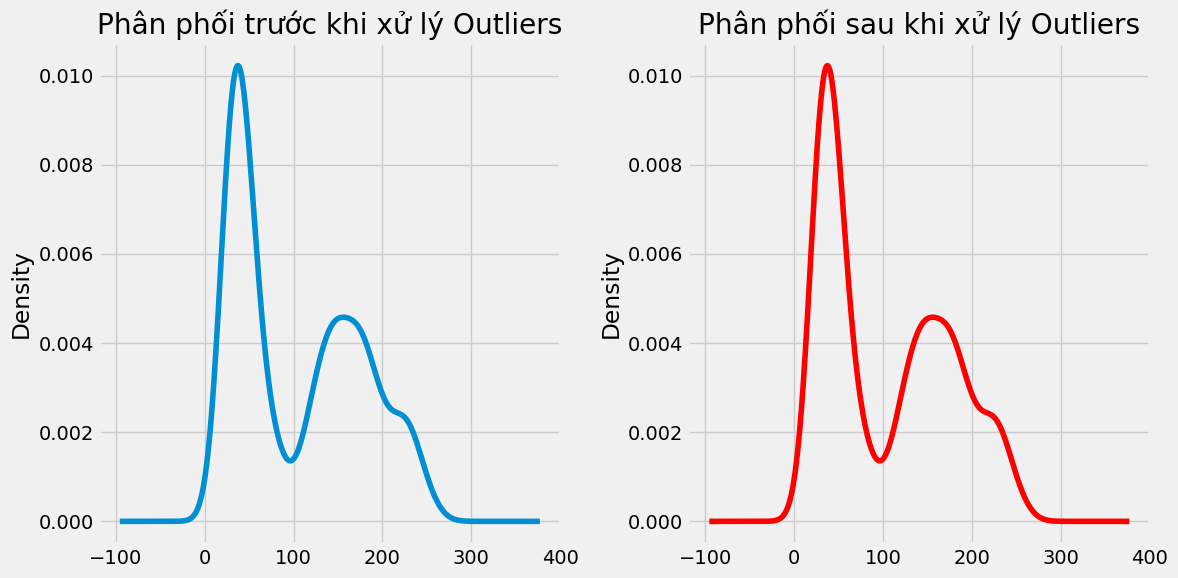

In [63]:
# Make a copy of df_close to store original for comparison
df_close_original = df_close.copy()

# Calculate IQR for outlier detection on df_close
Q1 = df_close.quantile(0.25)
Q3 = df_close.quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = (df_close < lower_bound) | (df_close > upper_bound)
print(f"Số lượng outliers được phát hiện trong df_close: {outliers.sum()}")

# Replace outliers with the median of the series
median_value = df_close.median()
df_close[outliers] = median_value # Modify df_close directly

print(f"Đã thay thế {outliers.sum()} outliers trong df_close bằng giá trị trung vị ({median_value:.4f}).")

# Visualize the distribution before and after outlier treatment
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df_close_original.plot(kind='kde')
plt.title('Phân phối trước khi xử lý Outliers')

plt.subplot(1, 2, 2)
df_close.plot(kind='kde', color='red')
plt.title('Phân phối sau khi xử lý Outliers')
plt.tight_layout()
plt.show()

In [64]:
stock_data.tail()


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2025-09-23,254.183594,254.429993,257.339996,253.580002,255.880005,60275200
2025-09-24,252.065643,252.309998,255.740005,251.039993,255.220001,42303700
2025-09-25,256.621216,256.869995,257.170013,251.710007,253.210007,55202100
2025-09-26,255.212601,255.460007,257.600006,253.779999,254.100006,46076300
2025-09-29,254.183594,254.429993,255.000000,253.009995,254.559998,40127700


# TRỰC QUAN HÓA DỮ LIỆU

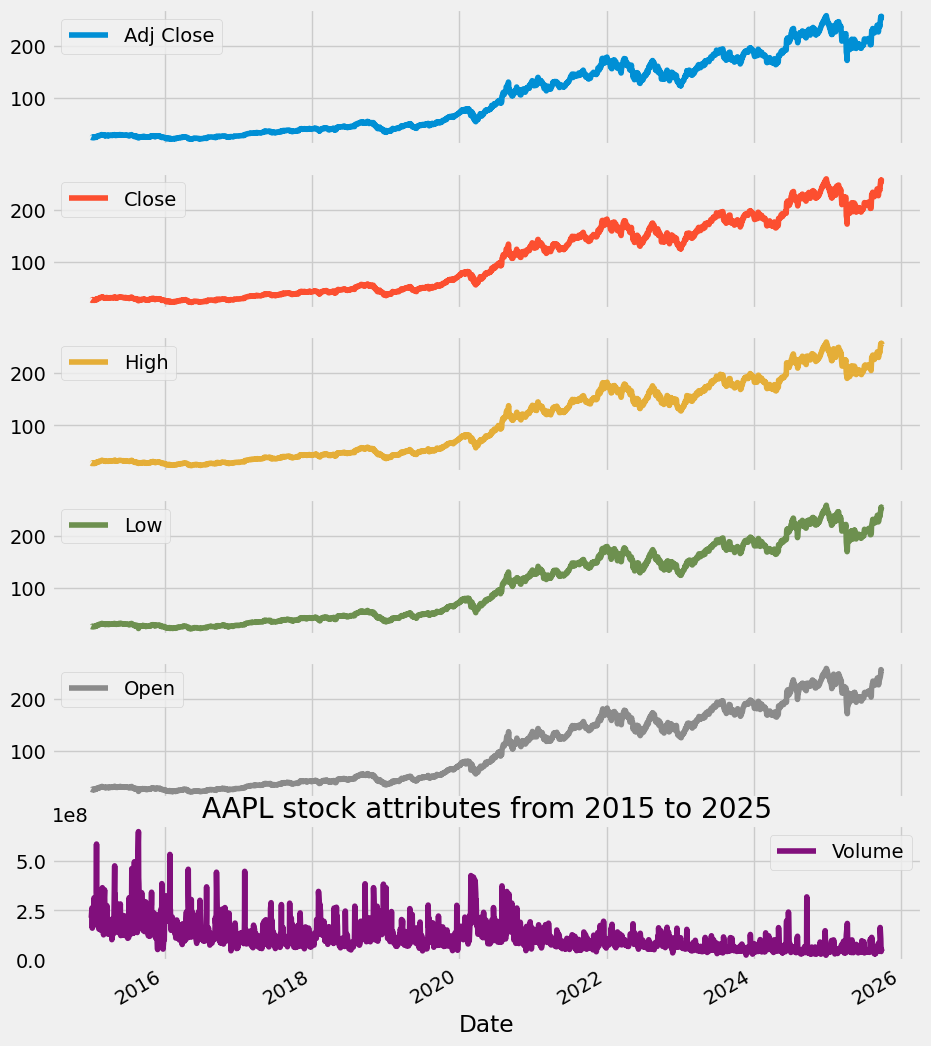

In [93]:
stock_data['2015':'2025'].plot(subplots=True, figsize=(10,14))
plt.title(f'{ticker} stock attributes from 2015 to 2025')
plt.show()

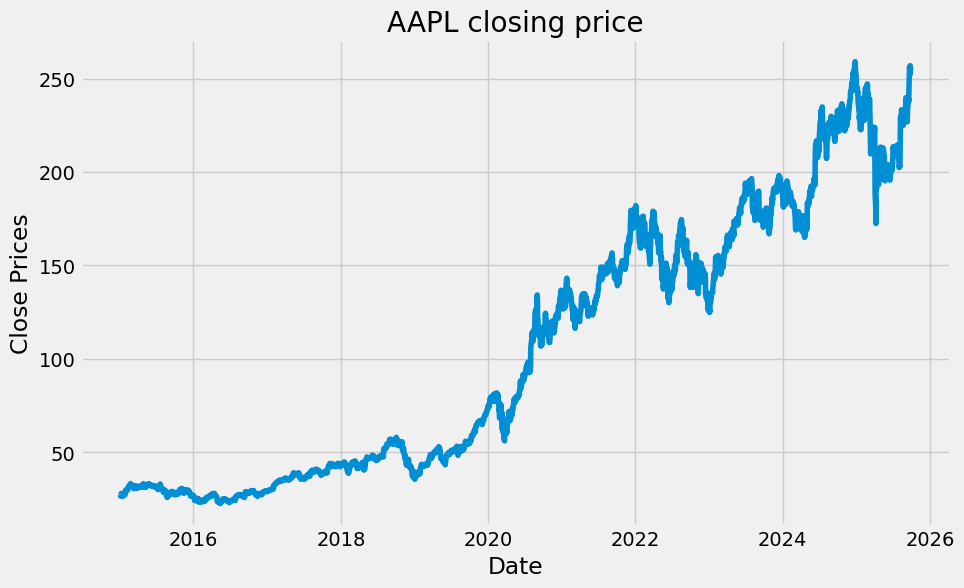

In [66]:
# Plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title(f'{ticker} closing price')
plt.show()

# TEST FOR STATIONARITY (ADF TEST)

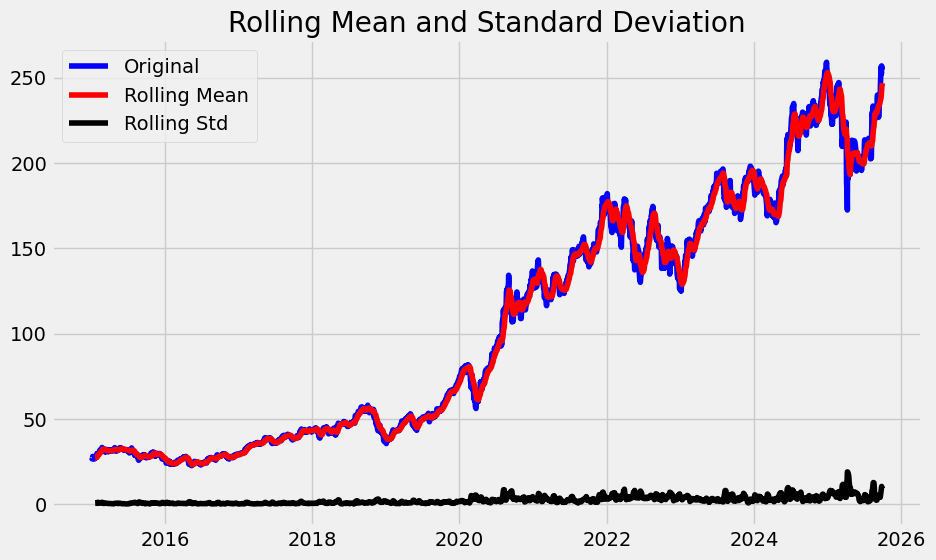

Results of dickey fuller test
Test Statistics                   0.334542
p-value                           0.978875
No. of lags used                 18.000000
Number of observations used    2682.000000
critical value (1%)              -3.432791
critical value (5%)              -2.862618
critical value (10%)             -2.567344
dtype: float64


In [67]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df_close)

**Nhận xét**

> * Ta thấy rằng giá trị p (p-value) lớn hơn 0.05, vì vậy chúng ta không thể bác bỏ giả thuyết gốc H (Null hypothesis). Thêm vào đó, thống kê kiểm định (test statistics) lớn hơn các giá trị tới hạn (critical values 5% ), do đó dữ liệu là không dừng.
> * Để thực hiện phân tích chuỗi thời gian (time series), chúng ta có thể cần phải loại bỏ tính mùa vụ (seasonality) và xu hướng (trend) ra khỏi chuỗi. Chuỗi kết quả (resultant series) sẽ trở nên dừng thông qua quá trình này.





## Decomposition

<Figure size 1000x600 with 0 Axes>

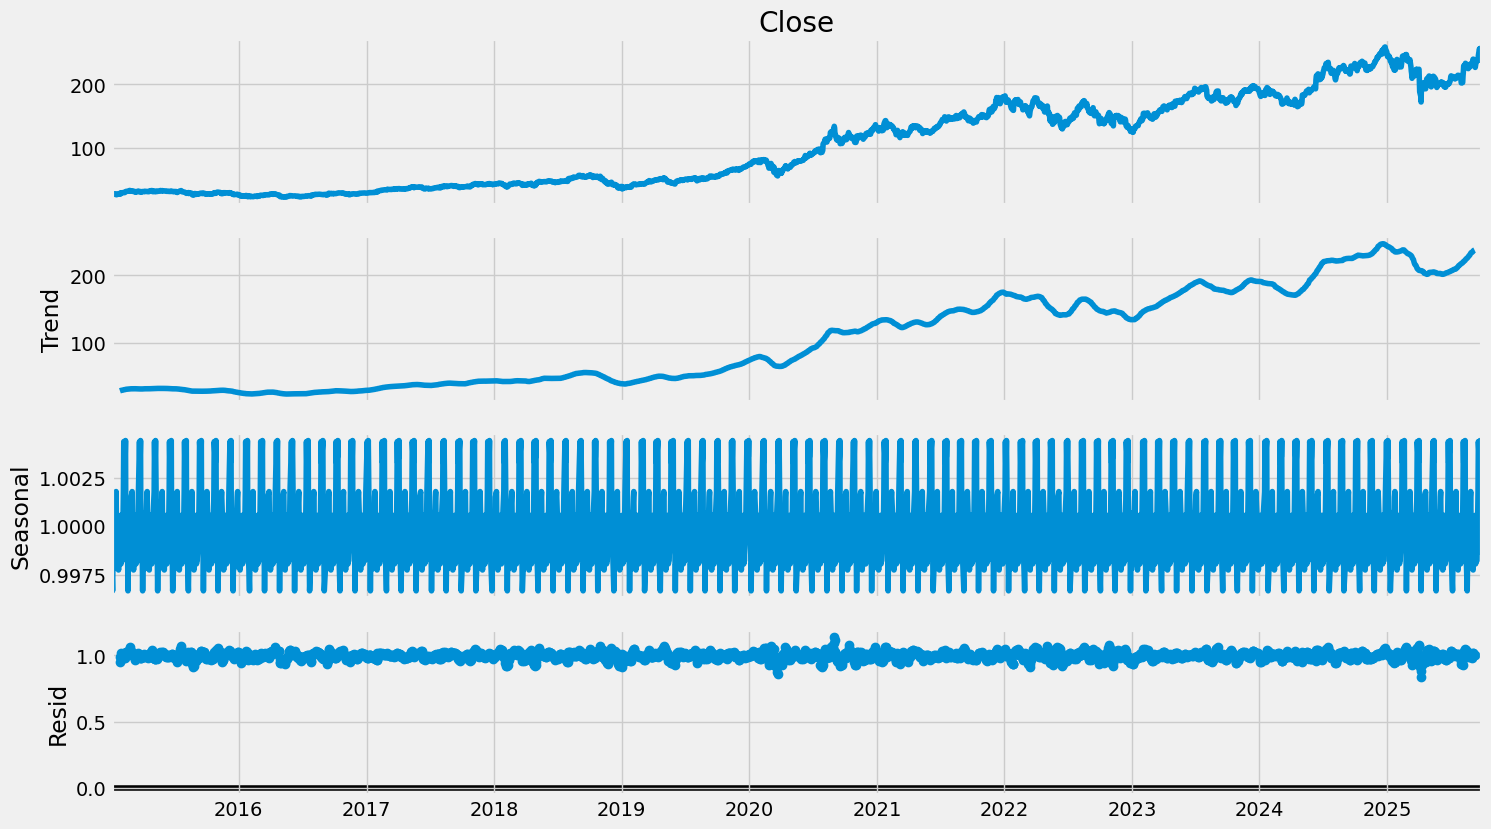

In [68]:
# Separate the trend and the seasonality from a time series
result = seasonal_decompose(df_close, model='multiplicative', period = 30) # The frequency is daily
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

Nhận xét:


>* Dựa vào biểu đồ ta thấy đang có xu hướng (trend) đi lên.
>* Biểu đồ có thay đổi theo chu kỳ (daily).
>* Residual cho thấy điểm dữ liệu biến động mạnh.




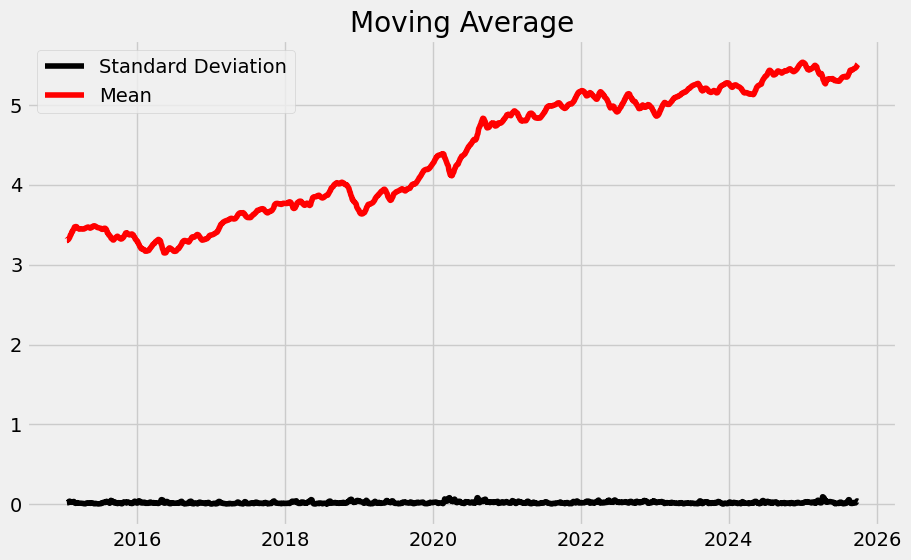

In [69]:
# Eliminate trend
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

# TRAINING ARIMA MODEL

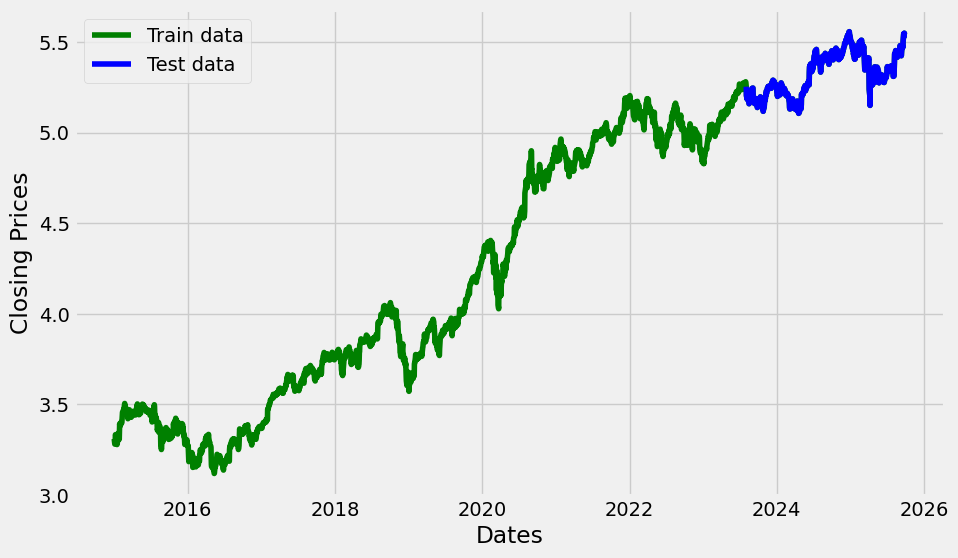

In [70]:
#split data into train and training set (80:20)
train_data, test_data = df_log[3:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11073.775, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11085.865, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11086.170, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11070.558, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11084.391, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-11084.322, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11082.304, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-11081.964, Time=0.42 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 3.299 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2157
Model:               SARIMAX(0, 1, 1)   Log Likelihood                5546.085
Date:                Wed, 12 Nov 2025   AIC                         -11086.170
Time:               

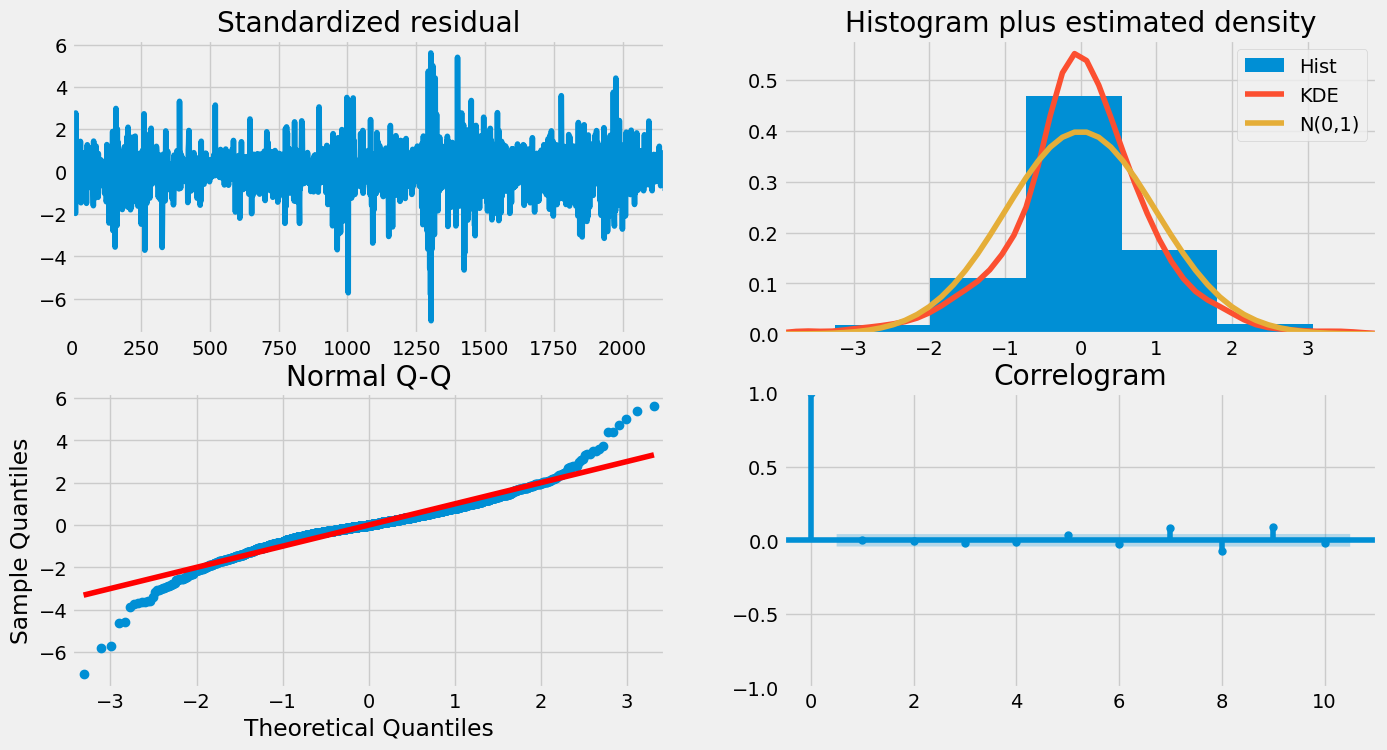

In [71]:
# Choose parameters p,q,d for ARIMA model by using auro_arima function
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Nhận xét:
> * Biểu đồ Correlogram (ACF) cho thấy mô hình đã nắm bắt tốt các kiểu mẫu (pattern) theo thời gian, vì không còn tự tương quan trong phần dư.
> * Biểu đồ (phần dư dao động mạnh rồi lại yếu) cho thấy một đặc điểm gọi là "biến động cụm" (volatility clustering). Rõ ràng, mô hình ARIMA giả định rằng phương sai (mức độ dao động) của phần dư là không đổi theo thời gian. Dữ liệu rõ ràng vi phạm điều này. Vậy ta chuyển qua xây dựng mô hình thích hợp để xử lý việc này là GARCH model.



## BUILDING ARIMA MODEL
ARIMA model sẽ có ý nghĩa như thế nào nếu bỏ qua volatility?

In [87]:
model = ARIMA(train_data, order=(0,1,1))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2157
Model:                 ARIMA(0, 1, 1)   Log Likelihood                5542.982
Date:                Wed, 12 Nov 2025   AIC                         -11081.964
Time:                        16:05:07   BIC                         -11070.612
Sample:                             0   HQIC                        -11077.811
                               - 2157                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0791      0.014     -5.638      0.000      -0.107      -0.052
sigma2         0.0003   5.96e-06     57.357      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.02   Jarque-

In [88]:
# Forecast
forecast_result = fitted.get_forecast(steps=len(test_data), alpha=0.05)
fc = forecast_result.predicted_mean
se = forecast_result.se_mean
conf = forecast_result.conf_int()

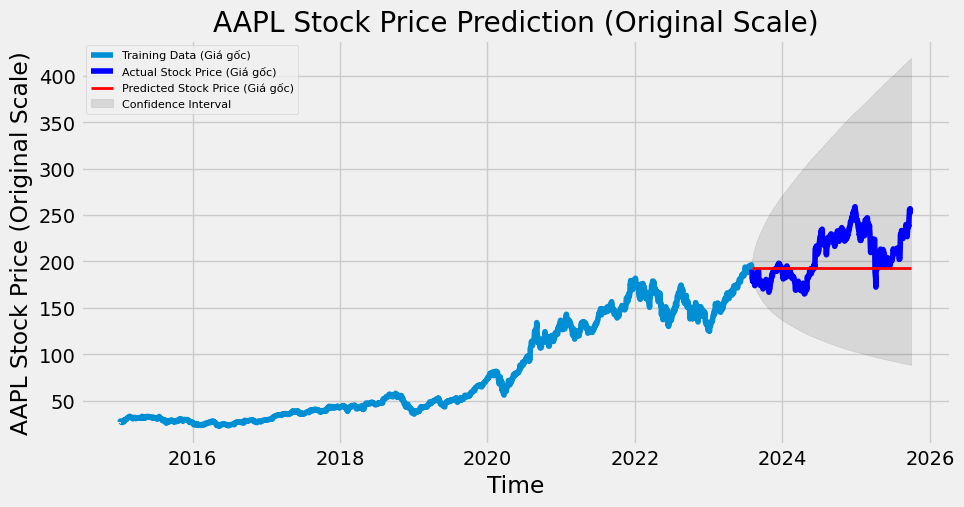

In [89]:
# Make as pandas series
fc_series = pd.Series(fc)
fc_series.index = test_data.index

lower_series = pd.Series(conf.iloc[:, 0])
lower_series.index = test_data.index

upper_series = pd.Series(conf.iloc[:, 1])
upper_series.index = test_data.index

# Plot: Dùng np.exp() để chuyển mọi thứ về dữ liệu gốc

plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='Training Data (Giá gốc)')
plt.plot(np.exp(test_data), color = 'blue', label='Actual Stock Price (Giá gốc)')
plt.plot(np.exp(fc_series), color = 'red', label='Predicted Stock Price (Giá gốc)', linewidth=2)

# Plot khoảng tin cậy
plt.fill_between(lower_series.index,
                 np.exp(lower_series),
                 np.exp(upper_series),
                 color='k', alpha=.10, label='Confidence Interval')

plt.title(f'{ticker} Stock Price Prediction (Original Scale)')
plt.xlabel('Time')
plt.ylabel(f'{ticker} Stock Price (Original Scale)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [76]:
# report performance
actual_prices = np.exp(test_data.values)
predicted_prices = np.exp(fc.values)

mse = mean_squared_error(test_data.values, fc.values)
print('MSE: '+str(mse))

mae = mean_absolute_error(test_data.values, fc.values)
print('MAE: '+str(mae))

rmse = math.sqrt(mse)
print('RMSE: '+str(rmse))

mape_orig = np.nanmean(np.abs(predicted_prices - actual_prices) / np.abs(actual_prices))
print('MAPE: ' + str(mape_orig))

MSE: 0.017771223889865538
MAE: 0.11271171093766369
RMSE: 0.13330875398812164
MAPE: 0.1067570469422847


Nhận xét:
*   Mô hình cho khoảng tin cậy khá lớn nên không thể dự báo được chính xác
*   Ta thấy chỉ số MAPE tương đối cao, có ý nghĩa mô hình bị sai lệch nhiều so với thực tế



## GARCH MODEL
Trong phân tích trước, chúng ta đã nhận thấy rằng phần dư (residuals) từ mô hình ARIMA hiển thị hiện tượng "biến động cụm" (volatility clustering). Điều này có nghĩa là các giai đoạn có biến động cao thường theo sau các giai đoạn biến động cao, và tương tự đối với các giai đoạn biến động thấp. Điều này được thể hiện rõ ràng qua biểu đồ "phần dư" của mô hình ARIMA, nơi phương sai của "phần dư" không ổn định theo thời gian. Thế nên ta dùng mô hình GARCH(p,q) (ví dụ GARCH(1,1)) để dự đoán phương sai của chính các "phần dư" đó.

## Tính toán phần dư ARIMA

Trích xuất phần dư (residuals) từ mô hình ARIMA đã fitted. Phần dư này sẽ là đầu vào cho mô hình GARCH.


In [77]:
arima_residuals = fitted.resid
print(arima_residuals)

Date
2015-01-07    3.293519
2015-01-08    0.037703
2015-01-09    0.004034
2015-01-12   -0.024630
2015-01-13    0.006892
                ...   
2023-07-27   -0.006214
2023-07-28    0.012926
2023-07-31    0.004183
2023-08-01   -0.003954
2023-08-02   -0.015924
Length: 2157, dtype: float64


## Phân tích ACF/PACF của Phần dư Bình phương để lựa chọn Tham số GARCH

Để xác định thứ tự `p` và `q` cho mô hình GARCH, chúng ta thường phân tích hàm tự tương quan (ACF) và hàm tự tương quan riêng phần (PACF) của phần dư bình phương (squared residuals) từ mô hình ARIMA.

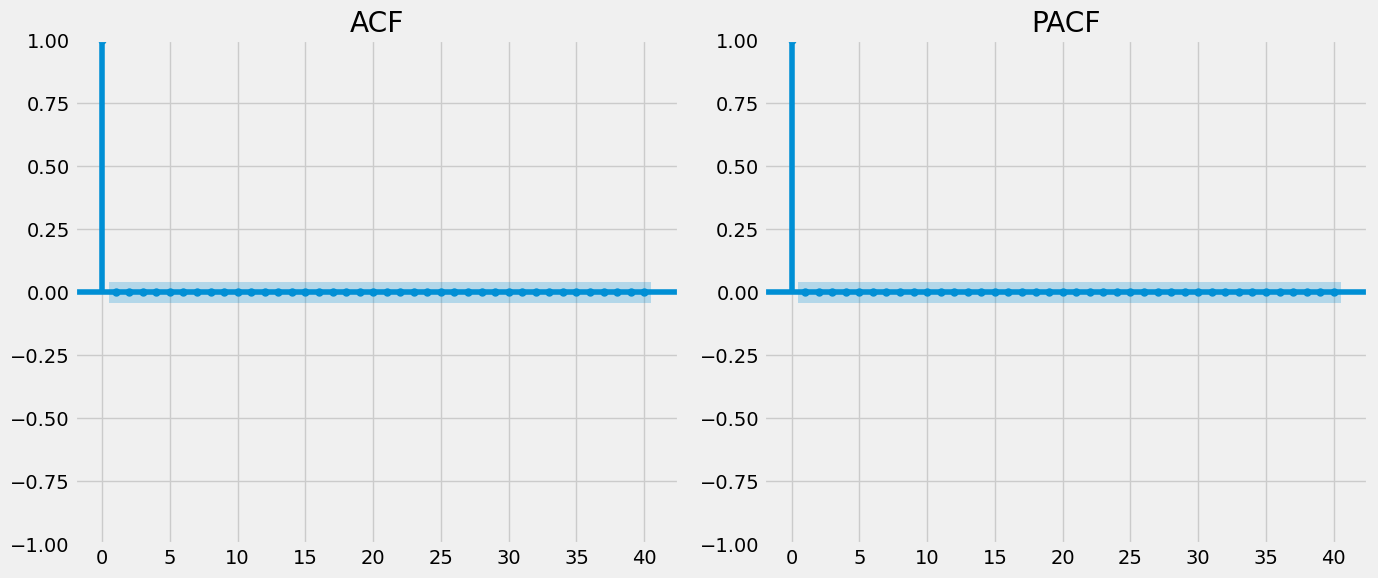

In [78]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate squared residuals
squared_arima_residuals = arima_residuals**2

# Plot ACF of squared residuals
plt.figure(figsize=(14, 6))
plot_acf(squared_arima_residuals, lags=40, ax=plt.subplot(121), title='ACF')

# Plot PACF of squared residuals
plot_pacf(squared_arima_residuals, lags=40, ax=plt.subplot(122), title='PACF')

plt.tight_layout()
plt.show()

*   **Biểu đồ ACF (Hàm tự tương quan):**
    *   `p`: Số lượng độ trễ đáng kể (significant lags) trong ACF của phần dư bình phương thường cho biết thứ tự `q` của GARCH (số lượng độ trễ của sai số bình phương). Tuy nhiên, đối với GARCH, chúng ta thường nhìn vào PACF để xác định `p`.

*   **Biểu đồ PACF (Hàm tự tương quan riêng phần):**
    *   `q`: Số lượng độ trễ đáng kể trong PACF của phần dư bình phương thường cho biết thứ tự `p` của GARCH (số lượng độ trễ của phương sai có điều kiện).

**Nhận xét:** Các độ trễ đáng kể là những thanh vượt ra ngoài vùng màu xanh lam (khoảng tin cậy). Mô hình GARCH(p,q) phổ biến nhất và thường là điểm khởi đầu tốt là GARCH(1,1), vì vậy nếu không có mẫu rõ ràng, GARCH(1,1) là một lựa chọn hợp lý.

In [79]:
garch_model = arch_model(arima_residuals, mean='Zero', vol='Garch', dist='t',o=1,p=1, q=1)
garch_fitted = garch_model.fit(disp='off')
print(garch_fitted.summary())

                        Zero Mean - GJR-GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                5609.85
Distribution:      Standardized Student's t   AIC:                          -11209.7
Method:                  Maximum Likelihood   BIC:                          -11181.3
                                              No. Observations:                 2157
Date:                      Wed, Nov 12 2025   Df Residuals:                     2157
Time:                              15:37:28   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omeg

## Dự báo độ biến động bằng GARCH

Sử dụng mô hình GARCH đã huấn luyện để dự báo độ biến động trong tương lai.


In [80]:
forecast_horizon = len(test_data)
garch_forecast = garch_fitted.forecast(horizon=forecast_horizon)

# Extract conditional variance
conditional_variance = garch_forecast.variance.iloc[-1]

# Create a pandas Series for volatility forecast with test_data index
volatility_forecast_series = pd.Series(np.sqrt(conditional_variance.values), index=test_data.index)


## Calculate GARCH-adjusted Confidence Intervals (Log Scale)

 Tính toán khoảng tin cậy trên và dưới mới cho dự báo đã biến đổi logarit (`fc_series`) sử dụng độ biến động dự báo từ mô hình GARCH (`volatility_forecast_series`)

In [81]:
z_score = 1.96

garch_lower_series = fc_series - z_score * volatility_forecast_series
garch_upper_series = fc_series + z_score * volatility_forecast_series

print("GARCH-adjusted Lower Confidence Interval (first 5 values):")
print(garch_lower_series.head())
print("\nGARCH-adjusted Upper Confidence Interval (first 5 values):")
print(garch_upper_series.head())

GARCH-adjusted Lower Confidence Interval (first 5 values):
Date
2023-08-03    5.219680
2023-08-04    5.215415
2023-08-07    5.211586
2023-08-08    5.208097
2023-08-09    5.204886
dtype: float64

GARCH-adjusted Upper Confidence Interval (first 5 values):
Date
2023-08-03    5.303861
2023-08-04    5.308126
2023-08-07    5.311955
2023-08-08    5.315444
2023-08-09    5.318655
dtype: float64


## Transform Forecasts and Intervals to Original Scale

Convert the ARIMA point forecast (`fc_series`) and the newly calculated GARCH-adjusted confidence intervals from log-transformed values back to the original price scale by applying the exponentiation function (`np.exp`).


In [82]:
forecast_original_scale = np.exp(fc_series)
garch_lower_original_scale = np.exp(garch_lower_series)
garch_upper_original_scale = np.exp(garch_upper_series)

print("Forecast on original scale (first 5 values):")
print(forecast_original_scale.head())
print("\nGARCH-adjusted Lower CI on original scale (first 5 values):")
print(garch_lower_original_scale.head())
print("\nGARCH-adjusted Upper CI on original scale (first 5 values):")
print(garch_upper_original_scale.head())

Forecast on original scale (first 5 values):
Date
2023-08-03    192.822579
2023-08-04    192.822579
2023-08-07    192.822579
2023-08-08    192.822579
2023-08-09    192.822579
Name: predicted_mean, dtype: float64

GARCH-adjusted Lower CI on original scale (first 5 values):
Date
2023-08-03    184.875075
2023-08-04    184.088230
2023-08-07    183.384632
2023-08-08    182.746029
2023-08-09    182.160091
dtype: float64

GARCH-adjusted Upper CI on original scale (first 5 values):
Date
2023-08-03    201.111734
2023-08-04    201.971342
2023-08-07    202.746253
2023-08-08    203.454745
2023-08-09    204.109180
dtype: float64


## Visualize Combined Forecast with GARCH CIs

Plot the original 'Close' price, the ARIMA point forecast, and the GARCH-adjusted confidence intervals (all in original price scale) to clearly illustrate the model's predictions and the dynamic uncertainty.


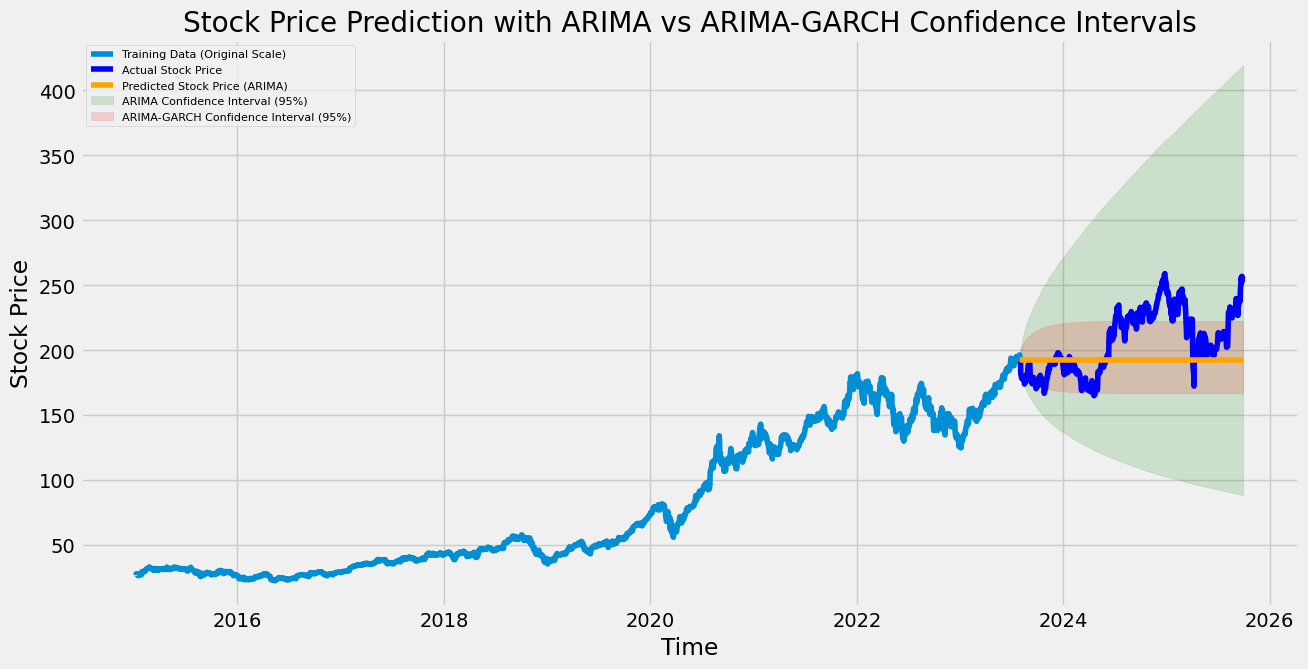

In [83]:
plt.figure(figsize=(14, 7), dpi=100) # Slightly larger figure for clarity
plt.plot(np.exp(train_data), label='Training Data (Original Scale)')
plt.plot(df_close[test_data.index], color='blue', label='Actual Stock Price')
plt.plot(forecast_original_scale, color='orange', label='Predicted Stock Price (ARIMA)')

# Convert original ARIMA CIs to original scale for plotting
arima_lower_original_scale = np.exp(lower_series)
arima_upper_original_scale = np.exp(upper_series)

# Plot ARIMA's original confidence interval
plt.fill_between(arima_lower_original_scale.index, arima_lower_original_scale, arima_upper_original_scale,
                 color='green', alpha=.15, label='ARIMA Confidence Interval (95%)')

# Plot GARCH-adjusted confidence interval
plt.fill_between(garch_lower_original_scale.index, garch_lower_original_scale, garch_upper_original_scale,
                 color='red', alpha=.15, label='ARIMA-GARCH Confidence Interval (95%)')

plt.title('Stock Price Prediction with ARIMA vs ARIMA-GARCH Confidence Intervals')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.grid(True)
plt.show()

Nhận xét:

*   Đường dự đoán trung bình (cam): Vẫn tương đối phẳng, thể hiện dự báo điểm của ARIMA.
*   Khoảng tin cậy ARIMA (xanh lá cây): Mở rộng đều, thể hiện độ không chắc chắn tĩnh.
*   Khoảng tin cậy ARIMA-GARCH (đỏ): Linh hoạt và thay đổi độ rộng theo thời gian, phản ánh chính xác hơn sự biến động thực tế của thị trường. Đây là điểm cải thiện chính, mang lại cái nhìn thực tế hơn về rủi ro dự báo.


# Kết luận
- Không thể sử dụng mô hình này để trading vì mô hình dự đoán thị trường sẽ đi ngang trong khi thực tế thị trường lại đang có xu hướng tăng rõ rệt.
- Trong khi đó có thể dùng nó như một công cụ risk management.
